# Chapter 14: Deep Computer Vision Using Convolutional Neural Networks
This work is partialy combined text and code from the book [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) and is only supposed to be used as reference and recommended to follow along with a copy of the Book puchased. 

The highlights of this chapter will be:
- History of CNNs.
- Building blocks of CNNs and implementation in Keras.
- CNN architectures.
- Object detection(placing bounding box over the object) and semantic segmentation (classifiying each pixel according to the class of the object it belongs to).




In [2]:
import tensorflow as tf
from tensorflow import keras

# The Visual Cortex
In a series of experiment performed by David h. Hubel and Torsten Wiesel on cats they were successful in showing that <mark> many neurons in the visual cortex have *local reeptive field*</mark>, i.e., they react only to visual stimuli located in a limited region of the visual field.


Later on by 1980, neocogitron came which gradually eveolved to what we now know today as *convolutional neural networks*. These networks has two new building blocks which we will take a look at.
- Covolutional layers
- Pooling layers

>🔵 **Why not simply use a deep neural network with fully connected layers for image recognition tasks?**
>
> For small it might be acceptable but for images of large dimension/size, it breaks because of the huge number of parameters it requires. Moreover the loss of information if using a small network.
>
> <mark>CNNs solve this problem using partially connected layers and weight sharing</mark>



# Convolutional Layers
A convolution is a mathematical operation that slides one function over another and measures the integral of their pointwise multiplication.

Convolutional layers are the first building blocks on CNNs. Each layer is represented in 2D (instead of 1D, line of neurons). Neurons in these layers are not connected to every single nerurons in their previous layer (for first layer, to the image) but instead to only neurons/pixels within a small rectangle/small receptive field.


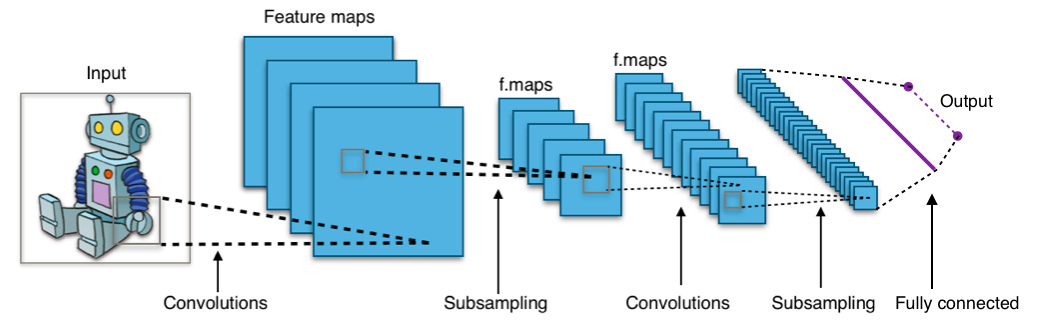
Image from Wikipedia


This helps in upper CNN layers accumulate higher-level features, while the lower layers deals with low-level features.

<mark>In order for a layer to have the same height and width as the previoous layer, it is common to add zeros around the inputs, this is called ***zero padding***.</mark>

To connect a large input layer to a much smaller layer we can spacing out the receptive field. <mark>This shift from one receptive field to the next is called ***stride*** represented by ($s_w$, $s_h)$</mark>

|Neurons in given layer|Connected to neurons of previous layer located in|
|---|---|
|row $i$| rows $i$ to $i+f_h-1$|
|column $j$| columns $j$ to $j+f_w-1$|

Where:
- $f_h$ represents height of receptive field
- $f_w$ reprents width of receptive field.
---
|Neurons in given layer|Connected to neurons of previous layer located in|
|---|---|
|row $i$| rows $i\times s_h$ to $i\times s_h+f_h-1$|
|column $j$| columns $j\times s_w$ to $j\times s_w+f_w-1$|

Where:
- $f_h$ represents height of receptive field
- $f_w$ reprents width of receptive field.
- $s_h$ represents vertical stride
- $s_w$ represent horizontal stride

## Filters
A neuron's weights can be represented as a small image the size of the receptive field, these are called ***filters*** (or ***convolution kernels). 

A layer full of neurons using the same filter outputs a ***feature map***, which highlights the areas in an image that activate the filter the most.

The convolution layer will automatically learn the most useful filters for its task during training phase.


## Stacking Multiple Feature Maps
Actually CNNs have multiple trainable filters which outputs one feature map per filter. It has one neuron per pixel in each feature map, and all neurons within a given feature map share the same parameters (i.e. the same weights and bias term).

>🔵 This fact reduces the amount of computation & once it can recognize a pattern in one location, it can recognize it in any other location.

Input images are also composed of multiple sublayers: one per ***color channel**.

Regular photographs are composed of usually 3 color channels but some like satellite imagery may contain more. 

Equation 14-1. Computing the output of a neuron in a convoltion lauer
$$z_{i,j,k}= b_k+\sum_{u=0}^{f_h-1}\sum_{v=0}^{f_w-1}\sum_{k'=0}^{f_{n'-1}}x_{i',j',k'}. w_{u,v,k',k}\enspace\text{with}\begin{cases}i'=i\times s_h+u\\j'=j\times s_w+v\end{cases}$$

In this equation:
- $z_{i,j,k}$ is the output of the neuron located in row $i$, column $j$ and feature map $k$ of convolution layer $l$.
- $s_h$, $s_w$ is vertical and horizontal strides. $f_h$, $f_w$ are the height and width of the receptive field. $f_{n'}$ is the number of feature maps in the previous layer ($l$ -1).
- $x_{i',j'k'}$ output of the neuron located in layer $l-1$, row $i'$, column $j'$, feature map $k'$ (or channel $k'$ if the previous layer is the input layer).
- $b_k$ is the bias term for the feature map $k$ (in layer $l$).
- w_{u,v,k',k} is the connection weight between any neuron in the feature map $k$ of the layer $l$ whose input is located in row $i$, column $j$ and feature map $k$.

## TensorFlow implementation 
A <mark>mini-batch is represented as a 4D tensor of shape [*mini-batch size*, *height*, *width*, *channels*].</mark> 

The <mark>weights of a convolutional lauer are represented as a 4D tensor of shape [$f_h$,$f_w$,$f_{n'}$,$f_n$].</mark>




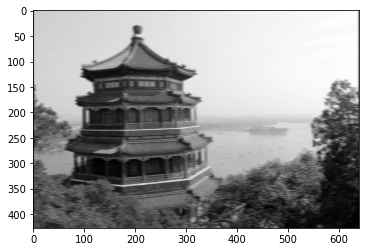

In [3]:
from sklearn.datasets import load_sample_image
import matplotlib.pyplot as plt
import numpy as np

# load sample iamges
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower]) # our mini batch
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # vertical line
filters[3, :, :, 1] = 1 # horizpmtal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

# plot 1st image's 2nd feature map
plt.imshow(outputs[0, :, :, 1], cmap="gray")

`padding` can be set either "`SAME`", "`VALID`", "`EXPLICIT`".

- If set to "`SAME`", the convolutionn layer uses zero padding if necessary.
- If set to "`VALID`", the covolutional layer does ***not*** use zero padding and may ignore some rows and columns at the bottom and right of the input image.

In TF, we define trainable convoltional layers with certain numbers of filters. The model learn the best filters by itself.

In [ ]:
conv = keras.layers.Conv2D(filters=32, 
                           kernel_size=3, 
                           strides=1, 
                           padding="same", 
                           activation="relu")

# Pooling Layers
The goals of these layers is to *subsample* the input image in order to reduce e computation load, the memory usage, and the number of parameters.

It as no weights, all it does is aggregate the inputs using an aggregation function such as max or mean.

The ***max-pooling layer*** are most commonly used and applies max aggregation function on its receptive field (defined by its ***pooling kernel***).

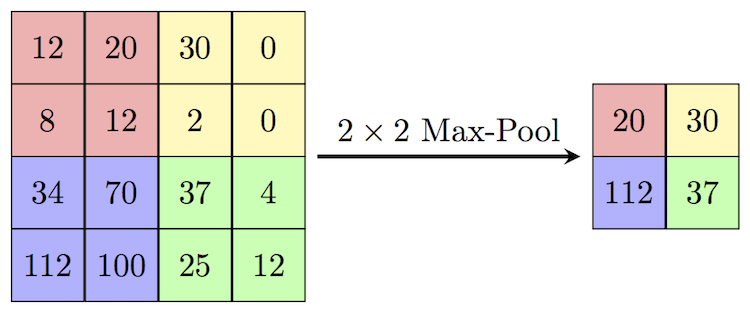

Image from computersciencewiki.

Max pooling layers also introduces some level of *invatience* to small translations.

It also offers a small amout of rotational invariance and a slight scale invarience (even if it is limited) can be useful incases were the prediction should not depend on these details, such as classification tasks.

Whereas some applicationsm invariance is not desiarable, like in the case of semantic segmentation (the task of classiying each pixel in an image according to the object that pixel belongs to. The goal in this case is *equivariance*, a small change to the inputs should lead to a corresonding small change in the ouput.

## TensorFlow implementation


In [ ]:
max_pool = keras.layers.MaxPool2D(pool_size=2)
avg_pool = keras.layers.AvgPool2D(pool_size=2)

Max pooling and average pooling can be performed along the depth dimension rather than the spatial dimensions (although it is not common). This leads to CNN leaning to be invariant to various features such as rotation, brightness, skew, color, etc.

Keras can't perform this type of pooling but a function in TensorFlow low level API can.

<mark>The first three values of `ksize` and `strides` should be 1, which indicates that the kernel size and stride along the batch, height, width dimension. The last value should be whatever the kernel size and stride you want along the depth dimension. **This must be a divisor of the input depth**.</mark>


In [ ]:
output = tf.nn.max_pool(images, 
                        ksize=(1, 1, 1, 3),
                        strides=(1, 1, 1, 3),
                        padding="VALID")

To include this in your code as keras layer, wrap it in keras lambda layer like this:

In [ ]:
depth_pool = keras.layers.Lambda(
    lambda X: tf.nn.max_pool(images, 
                        ksize=(1, 1, 1, 3),
                        strides=(1, 1, 1, 3),
                        padding="VALID")
)

One another type of pooling layers very commonly seen in CNN architectures is ***global average pooling layer***. <mark>It computes the mean of each feature map and outputs a single number per feature map and per instance.

In [ ]:
gloval_avg_pool = keras.layers.GlobalAveragePooling2D()

# CNN architectures
They ususlly stack a few convolutional layers(each one generally followed by a ReLU layer), then a pooling layer and combination of these two. At the top a regular feedforward neural network is added.
>🟢 A common mistake is to use convolution kerbels that are too large. This leads to large number of parameters and hence bigger computation. One exception is for the first convolution layer.

Let's write a simple CNN for fashion MNIST dataset.

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation="relu", padding="same", input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])

**It is common practice to double the number of filters after each pooling layer**. This is because the number of low-level features is often fairly low, but there are many way tp combine them into higher level features.

## LeNet-5
One of the classic CNN architecture created by Yann LeCun in 1998 and widely used for handwritten digit recognition (MNIST). The layers are as follower:

|**Layer**|**Type**|**Maps**|**Size**|**Kernel size**|**Stride**|**Activation**|
|---|---|---|---|---|---|---|
|Out |Fully connected|-|10|-|-|RBF|
|F6| Fully connected|-|84|-|-|tanh|
|C5| Convolution| 120|1x1|5x5|1|tanh|
|S4|Avg Pooling|16|5x5|2x2|2|tanh|
|C3|Convolution|16|10x10|5x5|1|tanh|
|S2|Avg Pooling|6|14x14|2x2|2|tanh|
|C1|Convolution|6|28x28|5x5|1|tanh|
|In|Input|1|32x32|-|-|-|

Couple of points for details:
- MNIST images are 28x28 pixels, but they are zero-padded to 32x32 pixels and normalized before being fed to the network. The rest of the network does not have padding.
- The average pooling layers's neuron computes the mean of its inputs, the mulitplies the result by  learnable coefficient (one per map) and adds a learnable bias term (again, one per map), then finally applies the activaton function.
- Most neurons in C3 maps are connected to neurons in only three or four S2 maps.
- In output layer each neuron outputs the square of the Eculidian distance between its input vector and its weight vector. These days Cross-entropy is now preferred by the way.



## AlexNet
Similer to Alex Krizhevskly, Ilya Sutskever and Geoffrey Hinton. It won the imageNet ILSVRC challenge of 2012, with top-five error of 17%.

It is similar to LeNet-5, only much larger and deeper, and it was the first to stacck convolutional layers directl on top of one another. 

|**Layer**|**Type**|**Maps**|**Size**|**Kernel size**|**Stride**|**Padding**|**Activation**|
|---|---|---|---|---|---|---|---|
|Out |Fully connected|-|1000|-|-||Spftmax|
|F9| Fully connected|-|4096|-|-||ReLU|
|F8| Fully connected|-|4096|-|-||ReLU|
|C7| Convolution| 256|13x13|53x|1|same|ReLU|
|C6| Convolution| 384|13x13|53x|1|same|ReLU|
|C5| Convolution| 384|13x13|53x|1|same|ReLU|
|S4|Max Pooling|256|13x13|3x3|2|valid|-|
|C3|Convolution|256|27x27|5x5|1|same|ReLU|
|S2|Max Pooling|96|27x27|3x3|2|valid|ReLU|
|C1|Convolution|96|55x55|11x11|4|valid|ReLU|
|In|Input|3(RGB)|227x227|-|-|-|ReLU|

On top of that it also adds a dropout layer for regularization with dropout rate of 50% to F8 and F9 and data augentation.

AlexNet also uses a competitive normalization step immediately after the ReLU step of layers C1 and C3, called ***Local response normalization*** (LRN): <mark>the most strongly activated neurons inhibit other neurons located at the same position in neighbouring feature maps. This encourages different feature maps to specialize, pushing them apart and forcing them to explore a wider range of features.

*Equation 14-2. Local response normalization*
$$b_i=a_i\Bigg(k+\alpha\sum_{j=j_\text{low}}^{f_\text{high}}a_j^2\Bigg)^{-\beta}\enspace\text{with}\begin{cases}j_\text{high}=\min\big(i+\frac{r}{2}, f_n-1\big)\\j_\text{low}=\max\big(0, i-\frac{r}{2}\big)\end{cases}$$

In this equation:
- $b_i$ is the normalized output od the neuron located in feature map $i$ at some row $u$ and column $v$.
- $a_i$ is the activation of that neuron after the ReLU step, but before normalization.
- $k$,$\alpha$,$\beta$ and $r$ are hyperparameters, $k$ is called *bias*, and $r$ is called  the *depth radius*.

In AlexNet, these hyperparameters are set as $r$=2, $\alpha$=0.00002, $\beta$= 0.75 and $k$ =1.

In TF this normalization can be implemented using `tf.nn.local_response_normalization()`.



## GoogLeNet
The trend moved on, this CNN architecture also got even deeper and won the ILSVRC 2014 challenge by bringing down tge top-five error rate below 7%. It was developed by Christian Szegedy from Google Research. 

The performancewas also reduced as the number of parameters decreased. This was hugely due to subnetworks called *inception modules*. 


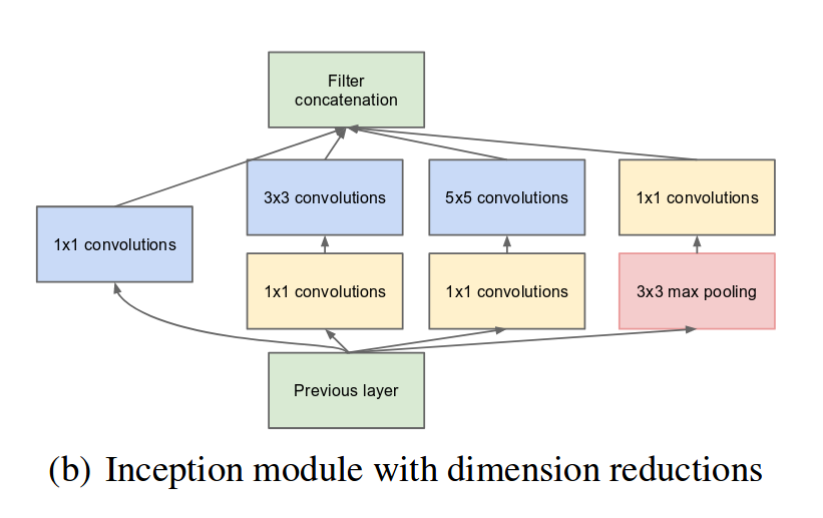

Image from deepai.org

The second set of convolution layers(Top one) uses different kernel sizes (1x1, 3x3, and 5x5), allowing them to capture patterns at different scales. Every single layer uses a stride of 1 and "`same`" padding. 

At end a *Depth concatenation layer* (this stacks the feature maps from all four top convolutional layers).

**Why convolution have convolutional layers with 1x1 kernels**
> 

- Altough they cannot capture spatial patterns, they can capture patterns along the depth dimension.
- These modules are configured to output feature maps than their inputs, so they serve as *bottleneck layers*, meaning they reduce dimensionality.
- Each pair of convolutional layer ([1x1, 3x3] and [1x1. 5x5]) acts like a single powerul convolutional layer.

>🔴 The number of convolutional kernels for each convolutional layer is a hyperparameter, thereby adding 6 more hyperparameter.



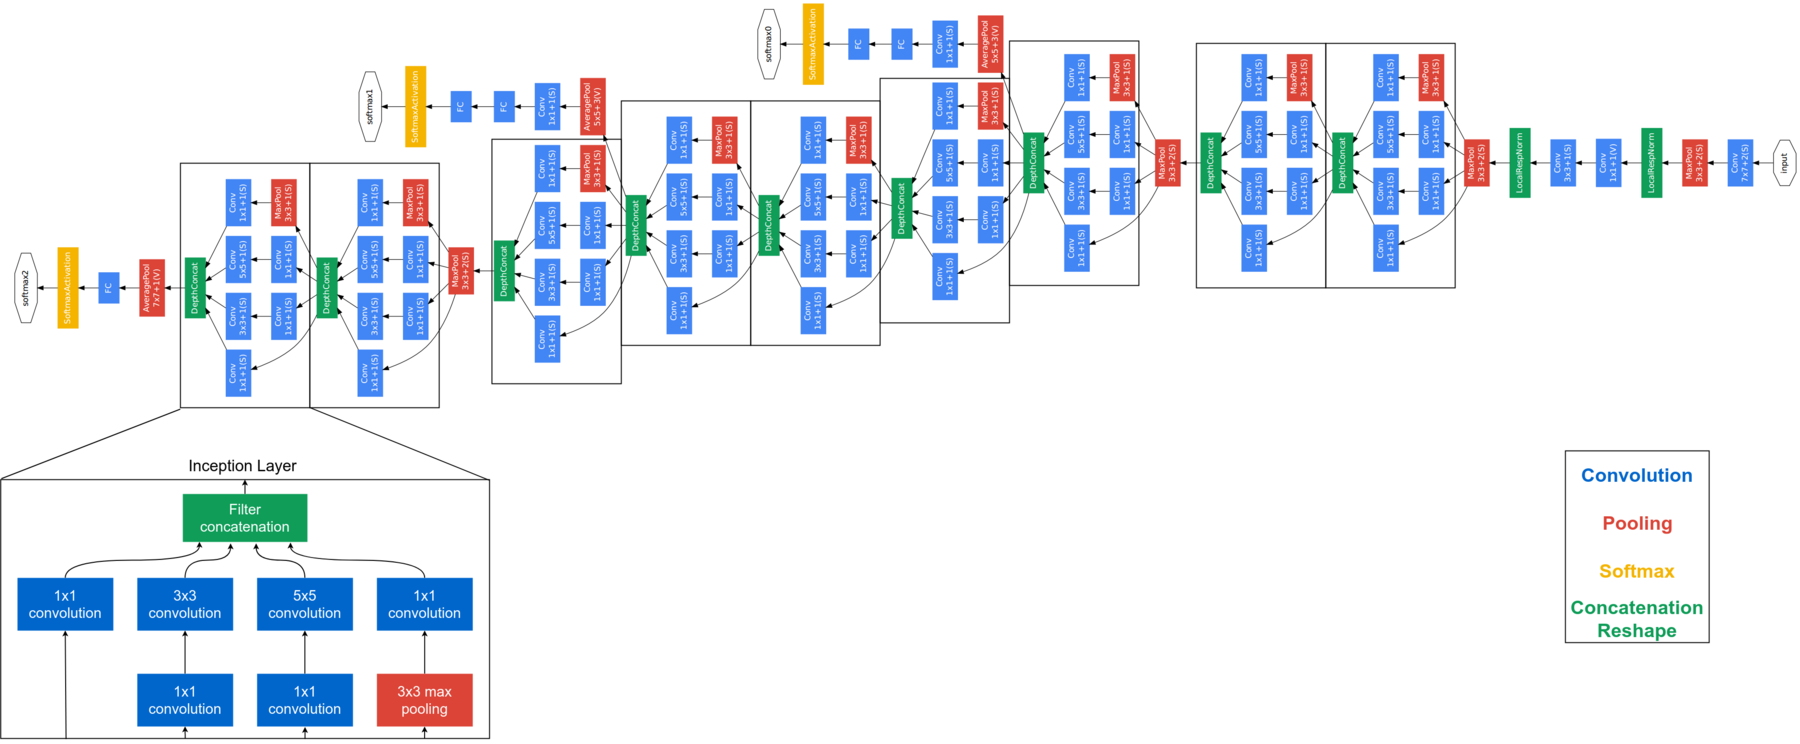

Image from [developer.ridgerun.com](https://developer.ridgerun.com/wiki/index.php?title=File:Googlenet.png)



## ResNet
ResNet or Residual network brought down the top-five error rate down to 3.6%, making it the winner model of ILSVRC 2015. 

The key to being able to train a deep neural network composed of about 152 layers was to use ***skip connections*** (also called as ***shortcut connections***): the signla feeding into a layer is alos added to the output of a layer a but higher up the stack.

<mark>When training a neural network, the goal is to make it model a target function $h(x)$. If you add the input $x$ to the output of the network, then the network will be forced to model $f(x)=h(X)-x$ rather than $h(x)$. This is called *residual learning*.</mark>

A ResNet is composed of smaller componenets called *residual units* which is small neural network with a skip connection. 

Each residual unit comprises of two convolutional layers (no pooling layers) with batch normalization and ReLU activation, using 3x3 kernels. 

> **When the strides is greater than 1 (reducing the height and width by the number of strides), the inputs cannot be directly added to the output of residual unit.**
>      
>For that we need to pass the inputs with a 1x1 convolutional layer with the same amount of stride as the strides appplied by the residual unit.



## Xception
Xception or Extreme Inceptions was proposed in 2016 by Francois Chollet (the author of Keras).

<mark>The architecture merges the ides of GoogLeNet and ResNet, but replaces the inception modules with ***depthwise separable convolutional layer*** (or ***separable convolution layer***).</mark>

**What's difference between a normal convoltional layer and separable convoltion layer ?**

A regular one:
- Uses filters try to simultaneousuly capture spatial patterns as well as cross-channel patterns.

<mark>A separable convolutional layer makes the strong assumptions that spatial patterns and cross-channel patterns can be modeled separately.</mark>
- Composed of two parts:
  - First one applies a single spatial filter for each input feature map.
  - Second part looks exculisvely for cross-channel patterns (a regular convolutional layer with 1x1 filters).

**Avoid separable convolutional layers right after layers that have too few channels** (ike the input layer, that's why Xception architecture starts with 2 regular convolutional layers).

>🟢 Separable convoltional layer use fewer parameters therby less memory and fewer computations, and even peform better than regular Convolutional layer, We should consider using them by default.

> Although ILSVRC 2016 challenge was won by CUImage team from the Chinese University of Hong Kong which appied a an ensemple technique and a sophisticated object-detection system called GBD-Net, the performance was impressive but complexity was debatable.


## SENet
SENet or **Squeeze and Excitation Network** was the winner architectue of ILSVRC pushing the top-five error further down to use 2.25%.

What it did was to extend the previous architectures like inception and ResNets and adding a small neural network, called an ***SE block***, to every unit in the original architecture (inception/residual unit), thus calling them *SE-Inception* or *SE-ResNet*.

### SE Block
<mark>This block analyzes the ouput of the unit it is attached to, focusing exclusively on the depth dimension (no spatial pattern), and it learns which features are usually most active together using which it recalliberates the original feature maps.</mark>

It comprises of:
- **A global average pooling**
  - Output the mean of features per feature maps.
- **A Dense layer with very few neurons**
  - Typically 16 times fewer than the number of input feature maps.
  - This creates a low dimensional feature map (embedding) of the distribution of the feature responses. 
  - This bottleneck step forces SE block to learn a general representation of the feature maps.
- **Dense Output layer**
  - The embedding from the previous layer creates a recalibration vector which is multiplied to the feature maps.
  - <mark>Irrelevant features (with low recalibration score) get scaled down while relevant features (with a recalibration score close to 1) are left untouched.</mark>

# Implementing a ResNet-34 CNN Using Keras
Resenet-34 is a ResNet with 34 layers (only counting the covolutional layers (including one at the input right before MaxPool layer and 2 in each residual unit) and fully connected layers).

Although we will usually load a pretrained network instead. but let's try building one.

First: A residual Unit.

In [16]:
class ResidualUnit(keras.layers.Layer):
  def __init__(self, filters, strides=1, activation="relu", **kwargs):
    super().__init__(**kwargs)
    self.activation = keras.activations.get(activation)
    self.main_layers =[
        keras.layers.Conv2D(filters, kernel_size=3, strides=strides, padding="same", use_bias=False),
        keras.layers.BatchNormalization(),
        self.activation,
        keras.layers.Conv2D(filters, kernel_size=3, strides=1, padding="same", use_bias=False),
        keras .layers.BatchNormalization()
    ]
    self.skip_layers = []
    if strides > 1:
      # When the strides is greater than 1,
      # the inputs cannot be directly added to the output of residual unit.
      # For that we need to pass the inputs with a 1x1 convolutional layer
      # with the same amount of stride as the strides appplied by the residual unit.
      self.skip_layers = [
          keras.layers.Conv2D(filters, kernel_size=1, strides=strides, padding="same", use_bias=False),
          keras.layers.BatchNormalization()
      ]
  
  def call(self, inputs):
    Z = inputs
    for layer in self.main_layers:
      Z = layer(Z)
    skip_Z = inputs
    for layer in self.skip_layers:
      skip_Z = layer(skip_Z)
    return self.activation(Z + skip_Z)


In [17]:
resnet = keras.models.Sequential()
resnet.add(keras.layers.Conv2D(64, 7, 
                               strides=2,
                               input_shape=[224, 224, 3],
                               padding="same",
                               use_bias=False))
resnet.add(keras.layers.BatchNormalization())
resnet.add(keras.layers.Activation("relu"))
resnet.add(keras.layers.MaxPool2D(pool_size=3,
                                  strides=2,
                                  padding="same"))
prev_filters = 64
# Resnet-34 has
# 3 RUs with 64 filters
# 4 RUs with 128 filters
# 6 RUs with 256 filters
# 3 RUs with 512 filters
for filters in [64]*3 + [128]*4 + [256]*6 + [512]*3:
  strides = 1 if filters == prev_filters else 2   # check if prev filters are same 
                                                  # i.e, when the no. of filters is same as in previous RU.
                                                  # if same filters keep 1 otherwise 2.
  resnet.add(ResidualUnit(filters, strides=strides))
  prev_filters = filters
resnet.add(keras.layers.GlobalAvgPool2D())
resnet.add(keras.layers.Flatten())
resnet.add(keras.layers.Dense(10, activation="softmax"))

# Using Pretrained Models from Keras
Let's load a pretrained esNet-50 model, pretrained on ImageNet.


In [ ]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102973440/102967424 [==============================] - 1s 0us/step


A ResNet-50 model expects 224x224-pixel images (others may expect other sizes). Use `tf.image.resize()` for resizing.

>🟢 `tf.image.resize()` does not preserve aspect ratio. We should crop it. to do both cropping and resize use `tf.image.crop_resize()`

In [ ]:
images_resized = tf.image.resize(images, [224, 224])

Next we preprocess these images, every model has a `preprocess_input()` function that you can use to preprocess your images.

These functions assume that pixel valuues range from 0 to 255.

In [ ]:
# here we multiply by 255 since we normalized it before.
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)

In [ ]:
Y_proba = model.predict(inputs)

The ouput as we know, contains a row for each input image and a column for each category.

#### `decode_predictions()`
If you want to display top K prediction, including the class name and the estimated probability.

In [ ]:
top_k = keras.applications.resnet50.decode_predictions(Y_proba, top=3)

for image_index in range(len(top_k)):
  print("Image #{}".format(image_index))
  for class_id, name, y_proba in top_k[image_index]:
    print("   {} - {:12s} {:.2f}".format(class_id, name, y_proba * 100))
  print()

Image #0
   n02825657 - bell_cote    82.35
   n03877845 - palace       6.75
   n03781244 - monastery    4.19

Image #1
   n03530642 - honeycomb    49.83
   n13040303 - stinkhorn    33.96
   n02206856 - bee          4.35



In some cases we might to classify images for which the classes are not part of ImageNet. In that case Transfer Learning might come handy.

# Pretrained Models for Transfer Learning
**First** lets' load the dataset for which we want to classify pictures of flowers.

In [9]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples # 3670
class_names = info.features["label"].names # ["dandelian", "daisy"]
n_classes = info.features["label"].num_classes

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [10]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

Next we need to do preprocessing. As we have seen earlier, we are going to use `preprocess_input()`. The CNN also expects 224x224 images so resize is alos required.

In [11]:
from functools import partial

def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000)
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

Let's ;pad an Xception model, let's exclude the top layer by setting `include_top=False` which removes the Global average pooling and the dense layer. We are going to add this according to our purpose.

In [12]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

Next we freeze the layers.

In [7]:
for layer in base_model.layers:
  layer.trainable = False

In [8]:
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
86/86 [==============================] - 670s 8s/step - loss: 1.3590 - accuracy: 0.7068 - val_loss: 0.9200 - val_accuracy: 0.8512
Epoch 2/5
86/86 [==============================] - 662s 8s/step - loss: 0.4852 - accuracy: 0.9024 - val_loss: 0.6981 - val_accuracy: 0.8639
Epoch 3/5
86/86 [==============================] - 659s 8s/step - loss: 0.2812 - accuracy: 0.9370 - val_loss: 0.6324 - val_accuracy: 0.8820
Epoch 4/5
86/86 [==============================] - 659s 8s/step - loss: 0.1976 - accuracy: 0.9342 - val_loss: 0.6553 - val_accuracy: 0.8730
Epoch 5/5
86/86 [==============================] - 657s 8s/step - loss: 0.1469 - accuracy: 0.9549 - val_loss: 0.6244 - val_accuracy: 0.8748


 Once the model finishes and has stagnant performace, that means top layers are pretty well trained. 

Then we are ready to unfreeze the layers (all layers or try unfreezing one-by-one).

Also we are going to decrease the learning rate to avoid damaging the pretrained weights.

In [ ]:
for layer in base_model.layers:
  layer.trainabble = True

optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, epochs=5, validation_data=valid_set)

# Classification and Localization
Localizing an object in a picture can be expressed as a regression task. <mark>To predict a bounding box around the object, a common approach is to predict the horizontal and vertical coordinates of the object's center, as well as its height and width.</mark>


In [15]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])

But then the dataset (i.e., flower dataset in our case) must have bounding boxes around the flowers.
For that we need to label the dataset by ourself or by using crowdsourcing.

We then need to create a dataset whose items will batches of preprocessed images along with their class labels and their bounding boxes. Each iteem should be a tuple of the form  **`(images, (class_labels, bounding_boxes))`**

For evaluation the metric we commonly use is ***Intersection over Union*** (IoU): <mark>the area of overlap between the predicted bounding box and the target bounding box, divided by the area of their union. </mark> 

In TF for this we use `tf.keras.metrics.MeanIoU`.

This works if we only single object per image.

# Object Detection
<mark>The task of classifying and localizing multiple objects in an image is called ***object detection***</mark>. 

Until few years ago, the common technique to perform this task was to move the CNN over the image in a grid. But this will detect the same object multiple times, at slightly different positions. To merge all this bounding boxes for one common object in an image *non-max suppression* technique was used.

1. First, we need to add an extra *objectness* output to your CNN, to estimate the probability that a flower is indeed present in the image. Then we get rid of all the bounding boxes for which the objectness score is below some threshold.
2. Find the bounding box with highest objectness score, and get rid of all the other bounding boxes that overlpa a lot with it (may with a IoU greate than some threshold). 
3. Repeat the step until there are no more bounding boxes to get rid of.

Although this a very slow process as we need to run the CNN multiple times. A better way is to use ***fully covolutional network*** (FCN).

## Fully Convollutional Networks
The idea was introduced by Jonanthan Long et al., in a 2015 papaer. The idea is to <mark>replace the dense layers at the top of a CNN by convolution layers.</mark>

To convert a dense layer to a convolution layer, the number of filters in the convolutional layer must be equal to the number of units in the dense layer, the filter size must be equal to the size of the input feature maps, and you must use "`valid`" padding.

While a dense layer expects a specific inputs size, a convolutional doesn't. All it expects is its inputs to have a specific number of channels since each kernel contains a different set of weights for each input channel. 

That means it can be trained and executed on images of any size!

## You Only Look Once (YOLO)
 